# 5. 성능 향상을 위한 방법

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cbQQ2CntUah9N0rsJdtWELseb-N_raFk?usp=sharing)

4장에서는 One-Stage Detector 모델인 RetinaNet을 활용해 의료용 마스크 탐지 모델을 구축해보았습니다. 이번 장에서는 Two-Stage Detector인 Faster R-CNN으로 객체 탐지를 해보도록 하겠습니다. 

5.1절부터 5.3절까지는 2장과 3장에서 확인한 내용을 바탕으로 데이터를 불러오고 훈련용, 시험용 데이터로 나눈 후 데이터셋 클래스를 정의하겠습니다. 5.4절에서는 torchvision API를 활용하여 사전 훈련된 모델을 불러오겠습니다. 5.5절에서는 전이 학습을 통해 모델 학습을 진행한 후 5.6절에서 예측값 산출 및 모델 성능을 확인해보겠습니다. 

실험에 앞서 Google Colab에서는 랜덤 GPU를 할당하고 있기 때문에 메모리 부족현상이 일어날 수 있습니다.

먼저 GPU를 확인 후에 메모리가 충분할 경우 실험을 하시길 권장합니다. 런타임을 초기화할 경우 새로운 GPU를 할당받으실 수 있습니다.

In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 5.1 데이터 불러오기


모델링 실습을 위해 2.1절에 나온 코드를 활용하여 데이터를 불러오겠습니다.

In [3]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.
Face Mask Detection.zip is done!


## 5.2 데이터 분리


3.3절에서 확인한 데이터 분리 방법을 활용하여 데이터를 분리하겠습니다. 

In [4]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


또한 모델링에 필요한 패키지를 불러오겠습니다. `torchvision`은 이미지 처리를 하기 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지가 내장되어 있습니다.

In [5]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## 5.3 데이터셋 클래스 정의

2.3절과 마찬가지로 바운딩 박스를 위한 함수들을 정의해줍니다.

In [23]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

또한 4.3절처럼 데이터셋 클래스와 데이터 로더를 정의해줍니다. 데이터셋은  `torch.utils.data.DataLoader` 함수를 통해 배치 사이즈는 4로 지정하여 불러오겠습니다.배치 사이즈는 개인의 메모리 크기에 따라 자유롭게 설정하면 됩니다. 

In [15]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 5.4 모델 불러오기

`torchvision.models.detection`에서는 Faster R-CNN API(`torchvision.models.detection.fasterrcnn_resnet50_fpn`)를 제공하고 있어 쉽게 구현이 가능합니다. 이는 COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, `pretrained=True/False`로 설정할 수 있습니다.

모델을 불러올 때 `num_classes`에 원하는 클래스 개수를 설정하고 모델을 사용하면 됩니다. Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 `num_classes`에 명시해주어야 합니다. 이번 데이터 셋에는 총 3개의 클래스가 있기 때문에 background 클래스까지 합해서 `num_classes`에 4를 할당하겠습니다.

In [7]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5.5 전이 학습

Face Mask Detection에 전이 학습을 실시해 보겠습니다. Face Mask Detection 데이터셋은 3개의 클래스로 이루어져 있지만 background 클래스를 포함하여 `num_classes`를 4로 설정한 후 모델을 불러옵니다.

GPU를 사용할 수 있는 환경이라면 device로 지정하여 불러온 모델을 GPU에 보내줍니다.

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

위의 출력되는 결과를 통해 Fastser R-CNN이 어떤 layer들로 구성되어 있는지 알 수 있습니다. 이 때, GPU 사용 가능 여부는 `torch.cuda.is_available()`를 통해 알 수 있습니다.

In [10]:
torch.cuda.is_available()

True

이제 모델이 만들어졌으니 학습을 해보겠습니다. 학습 횟수(`num_epochs`)는 5로 지정하고, SGD 방법을 통해 최적화 시켜보겠습니다. 각 하이퍼 파라미터는 자유롭게 수정하여 사용할 수 있습니다.

In [33]:
num_epochs = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

이제 학습을 시켜보겠습니다. 위에서 생성한 data_loader에서 한 배치씩 순서대로 모델에 사용하며, 이후 loss 계산을 통해 최적화를 수행합니다. 지정한 에폭만큼 반복하고 각 에폭마다 loss를 출력하여 확인합니다.

In [34]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 74.34998321533203, time : 273.16055250167847
epoch : 2, Loss : 50.06059646606445, time : 272.5033800601959
epoch : 3, Loss : 42.119712829589844, time : 272.21661353111267
epoch : 4, Loss : 36.70801544189453, time : 272.0769696235657
epoch : 5, Loss : 33.883331298828125, time : 272.2374768257141


학습시킨 가중치를 저장하고 싶다면, `torch.save`를 이용하여 저장해두고 나중에 언제든지 불러와 사용할 수 있습니다.

In [35]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [11]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## 5.6 예측

모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해보겠습니다. 우선 test_data_loader의 첫번째 배치에 대해서 결과를 출력해보았습니다. 아래와 같이 batch_size 만큼의 그림에 대해 바운딩 박스의 좌표(boxes)와 클래스(labels), 점수(scores)가 예측됩니다.

In [29]:
with torch.no_grad(): 
    
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        model.eval()
        pred = model(imgs)
        print(pred)
        break

[{'boxes': tensor([[213.8170,  60.3228, 257.5329,  99.4139],
        [116.9146,   2.2618, 133.8999,  17.7742]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9491, 0.9181], device='cuda:0')}, {'boxes': tensor([[218.1418, 100.7296, 257.6489, 138.6261],
        [130.1944, 111.2079, 180.6899, 151.8661],
        [302.6493, 131.3666, 332.1136, 158.1566],
        [ 40.7404, 110.1605,  67.1615, 140.2841],
        [164.7895,  90.4779, 179.6878, 107.9786],
        [ 28.9578,  89.8970,  45.3396, 104.7100],
        [ 83.2690,  84.5476,  95.3321,  96.8537],
        [  1.6865, 104.6856,  21.2249, 128.0417],
        [ 82.4948,  86.1961,  95.4540, 111.2381],
        [257.7352,  91.0032, 269.2602, 103.0512],
        [220.4953, 130.3433, 262.5282, 164.9134],
        [112.8341,  83.7270, 131.0779, 107.2787],
        [  1.0475, 104.9788,  22.3046, 128.0129],
        [  1.4895, 104.1338,  22.4582, 127.9700],
        [294.6094,  85.9146, 304.8036,  97.2667],
        [ 66.

'scores'에는 점수, 또는 해당 클래스일 신뢰도 값이 저장됩니다. 0.5 이상인 것만 추출하기 위해 아래와 같은 함수를 정의하겠습니다. 

In [26]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [32]:
with torch.no_grad(): 

    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[213.8170,  60.3228, 257.5329,  99.4139],
        [116.9146,   2.2618, 133.8999,  17.7742]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9491, 0.9181], device='cuda:0')}, {'boxes': tensor([[218.1418, 100.7296, 257.6489, 138.6261],
        [130.1944, 111.2079, 180.6899, 151.8661],
        [302.6493, 131.3666, 332.1136, 158.1566],
        [ 40.7404, 110.1605,  67.1615, 140.2841],
        [164.7895,  90.4779, 179.6878, 107.9786],
        [ 28.9578,  89.8970,  45.3396, 104.7100],
        [ 83.2690,  84.5476,  95.3321,  96.8537],
        [  1.6865, 104.6856,  21.2249, 128.0417],
        [ 82.4948,  86.1961,  95.4540, 111.2381]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.9930, 0.9866, 0.9491, 0.9489, 0.9451, 0.9442, 0.9338, 0.8371, 0.5053],
       device='cuda:0')}]


아래 `plot_image_from_output` 함수를 통해 예측한 바운딩 박스를 그림으로 출력해보겠습니다. Target이 실제 바운딩 박스 위치이며 Prediction이 모델의 예측 결과입니다. 모델이 실제 바운딩 박스의 위치를 잘 찾은 것을 확인할 수 있습니다. 


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


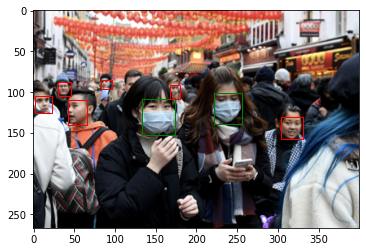

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0')


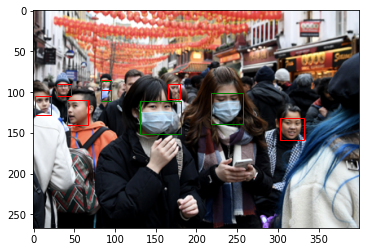

In [33]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

이번엔 전체 시험 데이터에 대해서 예측 결과를 평가해보도록 하겠습니다. 예측 평가 지표로는 mAP를 사용합니다.

In [34]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:26<00:00,  3.26it/s]


In [35]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [36]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5902535719285487
AP : tensor([0.8146, 0.9562, 0.0000], dtype=torch.float64)


5 epoch만 학습했는데 30 epoch을 학습시킨 RetinaNet과 성능이 유사한 것을 확인할 수 있습니다. 

추가 설명

마무리 문장